## Context
In this notebook, we elaborate on our data so that each service includes multiple metrics (RED here - request rate, error rate, and duration / latency). 
Note: Took a best stab at this modification with the power of o1-preview and claude, thanks genai :) Did a quick perusal of it... seemed chill for hack purposes. 

## Imports

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import truncexpon, halfnorm, bernoulli
import json
import matplotlib.pyplot as plt

## Helpers

In [4]:
def create_observed_data(unobserved_intrinsic_metrics):
    ''' 
    This function takes in the unobserved intrinsic metrics and simulates the observed metrics for each service.
    '''
    observed_metrics = {}
    num_samples = len(unobserved_intrinsic_metrics['Product DB']['latency'])

    # Initialize observed metrics for each component
    components = ['Product DB', 'Customer DB', 'Order DB', 'Shipping Cost Service',
                  'Caching Service', 'Product Service', 'Auth Service', 'Order Service',
                  'API', 'www', 'Website']
    for comp in components:
        observed_metrics[comp] = {
            'latency': np.zeros(num_samples),
            'request_rate': np.zeros(num_samples),
            'error_rate': np.zeros(num_samples)
        }

    # Simulate metrics for databases
    for db in ['Product DB', 'Customer DB', 'Order DB']:
        observed_metrics[db]['latency'] = unobserved_intrinsic_metrics[db]['latency']
        observed_metrics[db]['request_rate'] = unobserved_intrinsic_metrics[db]['request_rate']
        observed_metrics[db]['error_rate'] = unobserved_intrinsic_metrics[db]['error_rate']

    # Simulate metrics for Shipping Cost Service
    observed_metrics['Shipping Cost Service']['latency'] = unobserved_intrinsic_metrics['Shipping Cost Service']['latency']
    observed_metrics['Shipping Cost Service']['request_rate'] = unobserved_intrinsic_metrics['Shipping Cost Service']['request_rate']
    observed_metrics['Shipping Cost Service']['error_rate'] = unobserved_intrinsic_metrics['Shipping Cost Service']['error_rate']

    # Simulate metrics for Caching Service
    cache_hit = bernoulli.rvs(0.5, size=num_samples)
    observed_metrics['Caching Service']['latency'] = cache_hit * observed_metrics['Product DB']['latency'] + unobserved_intrinsic_metrics['Caching Service']['latency']
    observed_metrics['Caching Service']['request_rate'] = observed_metrics['Product DB']['request_rate']
    observed_metrics['Caching Service']['error_rate'] = (
        cache_hit * observed_metrics['Product DB']['error_rate'] +
        (1 - cache_hit) * unobserved_intrinsic_metrics['Caching Service']['error_rate']
    )

    # Simulate metrics for Product Service
    max_latency = np.maximum.reduce([
        observed_metrics['Shipping Cost Service']['latency'],
        observed_metrics['Caching Service']['latency'],
        observed_metrics['Customer DB']['latency']
    ])
    observed_metrics['Product Service']['latency'] = max_latency + unobserved_intrinsic_metrics['Product Service']['latency']
    observed_metrics['Product Service']['request_rate'] = observed_metrics['Customer DB']['request_rate']

    # Error rate propagation for Product Service
    upstream_errors = 1 - (
        (1 - observed_metrics['Shipping Cost Service']['error_rate']) *
        (1 - observed_metrics['Caching Service']['error_rate']) *
        (1 - observed_metrics['Customer DB']['error_rate'])
    )
    observed_metrics['Product Service']['error_rate'] = np.maximum(upstream_errors, unobserved_intrinsic_metrics['Product Service']['error_rate'])

    # Simulate metrics for Auth Service
    observed_metrics['Auth Service']['latency'] = observed_metrics['Customer DB']['latency'] + unobserved_intrinsic_metrics['Auth Service']['latency']
    observed_metrics['Auth Service']['request_rate'] = observed_metrics['Customer DB']['request_rate']

    # Error rate propagation for Auth Service
    observed_metrics['Auth Service']['error_rate'] = np.maximum(
        observed_metrics['Customer DB']['error_rate'],
        unobserved_intrinsic_metrics['Auth Service']['error_rate']
    )

    # Simulate metrics for Order Service
    observed_metrics['Order Service']['latency'] = observed_metrics['Order DB']['latency'] + unobserved_intrinsic_metrics['Order Service']['latency']
    observed_metrics['Order Service']['request_rate'] = observed_metrics['Order DB']['request_rate']

    # Error rate propagation for Order Service
    observed_metrics['Order Service']['error_rate'] = np.maximum(
        observed_metrics['Order DB']['error_rate'],
        unobserved_intrinsic_metrics['Order Service']['error_rate']
    )

    # Simulate metrics for API
    observed_metrics['API']['latency'] = (
        observed_metrics['Product Service']['latency'] +
        observed_metrics['Auth Service']['latency'] +
        observed_metrics['Order Service']['latency'] +
        unobserved_intrinsic_metrics['API']['latency']
    )
    observed_metrics['API']['request_rate'] = observed_metrics['Product Service']['request_rate']

    # Error rate propagation for API
    upstream_errors = 1 - (
        (1 - observed_metrics['Product Service']['error_rate']) *
        (1 - observed_metrics['Auth Service']['error_rate']) *
        (1 - observed_metrics['Order Service']['error_rate'])
    )
    observed_metrics['API']['error_rate'] = np.maximum(upstream_errors, unobserved_intrinsic_metrics['API']['error_rate'])

    # Simulate metrics for www
    observed_metrics['www']['latency'] = (
        observed_metrics['API']['latency'] +
        unobserved_intrinsic_metrics['www']['latency']
    )
    observed_metrics['www']['request_rate'] = observed_metrics['API']['request_rate']

    # Error rate propagation for www
    observed_metrics['www']['error_rate'] = np.maximum(
        observed_metrics['API']['error_rate'],
        unobserved_intrinsic_metrics['www']['error_rate']
    )

    # Simulate metrics for Website
    observed_metrics['Website']['latency'] = (
        observed_metrics['www']['latency'] +
        unobserved_intrinsic_metrics['Website']['latency']
    )
    observed_metrics['Website']['request_rate'] = observed_metrics['www']['request_rate']

    # Error rate propagation for Website
    observed_metrics['Website']['error_rate'] = np.maximum(
        observed_metrics['www']['error_rate'],
        unobserved_intrinsic_metrics['Website']['error_rate']
    )

    # Create the DataFrame in the desired format
    data_rows = []

    for time_index in range(num_samples):
        for comp in components:
            data_row = {
                'time_index': time_index,
                'service': comp,
                'rate': observed_metrics[comp]['request_rate'][time_index],
                'error_rate': observed_metrics[comp]['error_rate'][time_index],
                'duration': observed_metrics[comp]['latency'][time_index]
            }
            data_rows.append(data_row)

    df = pd.DataFrame(data_rows)
    return df

def unobserved_intrinsic_metrics_normal(num_samples):
    ''' 
    This function simulates the unobserved intrinsic metrics for each service.
    '''
    metrics = {}
    components = ['Website', 'www', 'API', 'Auth Service', 'Product Service', 'Order Service',
                  'Shipping Cost Service', 'Caching Service', 'Order DB', 'Customer DB', 'Product DB']
    for comp in components:
        metrics[comp] = {}
        # Latency
        if comp in ['Website', 'www']:
            metrics[comp]['latency'] = truncexpon.rvs(b=3, scale=0.2, size=num_samples)
        elif comp == 'API':
            metrics[comp]['latency'] = halfnorm.rvs(loc=0.5, scale=0.2, size=num_samples)
        elif comp in ['Auth Service', 'Product Service', 'Shipping Cost Service', 'Caching Service']:
            metrics[comp]['latency'] = halfnorm.rvs(loc=0.1, scale=0.2, size=num_samples)
        elif comp == 'Order Service':
            metrics[comp]['latency'] = halfnorm.rvs(loc=0.5, scale=0.2, size=num_samples)
        elif comp in ['Order DB', 'Customer DB', 'Product DB']:
            metrics[comp]['latency'] = truncexpon.rvs(b=5, scale=0.2, size=num_samples)
        else:
            metrics[comp]['latency'] = halfnorm.rvs(loc=0.1, scale=0.2, size=num_samples)

        # Request Rate
        if comp == 'Website':
            metrics[comp]['request_rate'] = np.random.poisson(lam=1000, size=num_samples)
        elif comp in ['www', 'API']:
            metrics[comp]['request_rate'] = np.random.poisson(lam=950, size=num_samples)
        else:
            metrics[comp]['request_rate'] = np.random.poisson(lam=900, size=num_samples)

        # Error Rate
        metrics[comp]['error_rate'] = np.random.beta(a=1, b=100, size=num_samples)

    return metrics

def unobserved_intrinsic_metrics_anomalous(num_samples):
    '''
    This function introduces an anomaly in the Caching Service's latency and error rate.
    '''
    metrics = unobserved_intrinsic_metrics_normal(num_samples)

    # Introduce anomaly in Caching Service
    metrics['Caching Service']['latency'] = 2 + halfnorm.rvs(loc=0.1, scale=0.1, size=num_samples)
    metrics['Caching Service']['error_rate'] = np.random.beta(a=10, b=90, size=num_samples)  # Higher error rate

    return metrics

In [5]:
def plot_normal_vs_anomalous_metrics(normal_data, amomalous_data):
    '''
    This function plots the mean of each metric per service for normal and anomalous data.
    '''
    aggs_norm = normal_data.groupby('service').agg({
        'rate': 'mean',
        'error_rate': 'mean',
        'duration': 'mean'
    })

    aggs_anom = anomalous_data.groupby('service').agg({
        'rate': 'mean',
        'error_rate': 'mean',
        'duration': 'mean'
    })

    metrics = ['rate', 'error_rate', 'duration']
    services = aggs_norm.index

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Comparison of Normal vs Anomalous Metrics by Service. Mean of each metric.')

    for i, metric in enumerate(metrics):
        ax = axes[i]
        x = range(len(services))
        width = 0.35
        
        ax.bar([xi - width/2 for xi in x], aggs_norm[metric], width, label='Normal', alpha=0.8)
        ax.bar([xi + width/2 for xi in x], aggs_anom[metric], width, label='Anomalous', alpha=0.8)
        
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(services, rotation=45, ha='right')
        ax.legend()

    plt.tight_layout()
    plt.show()

## Workspace

### Generate synthetic data

In [6]:
# Generate normal data
normal_metrics = unobserved_intrinsic_metrics_normal(10000)
normal_data = create_observed_data(normal_metrics)

# Generate anomalous data
anomalous_metrics = unobserved_intrinsic_metrics_anomalous(1000)
anomalous_data = create_observed_data(anomalous_metrics)

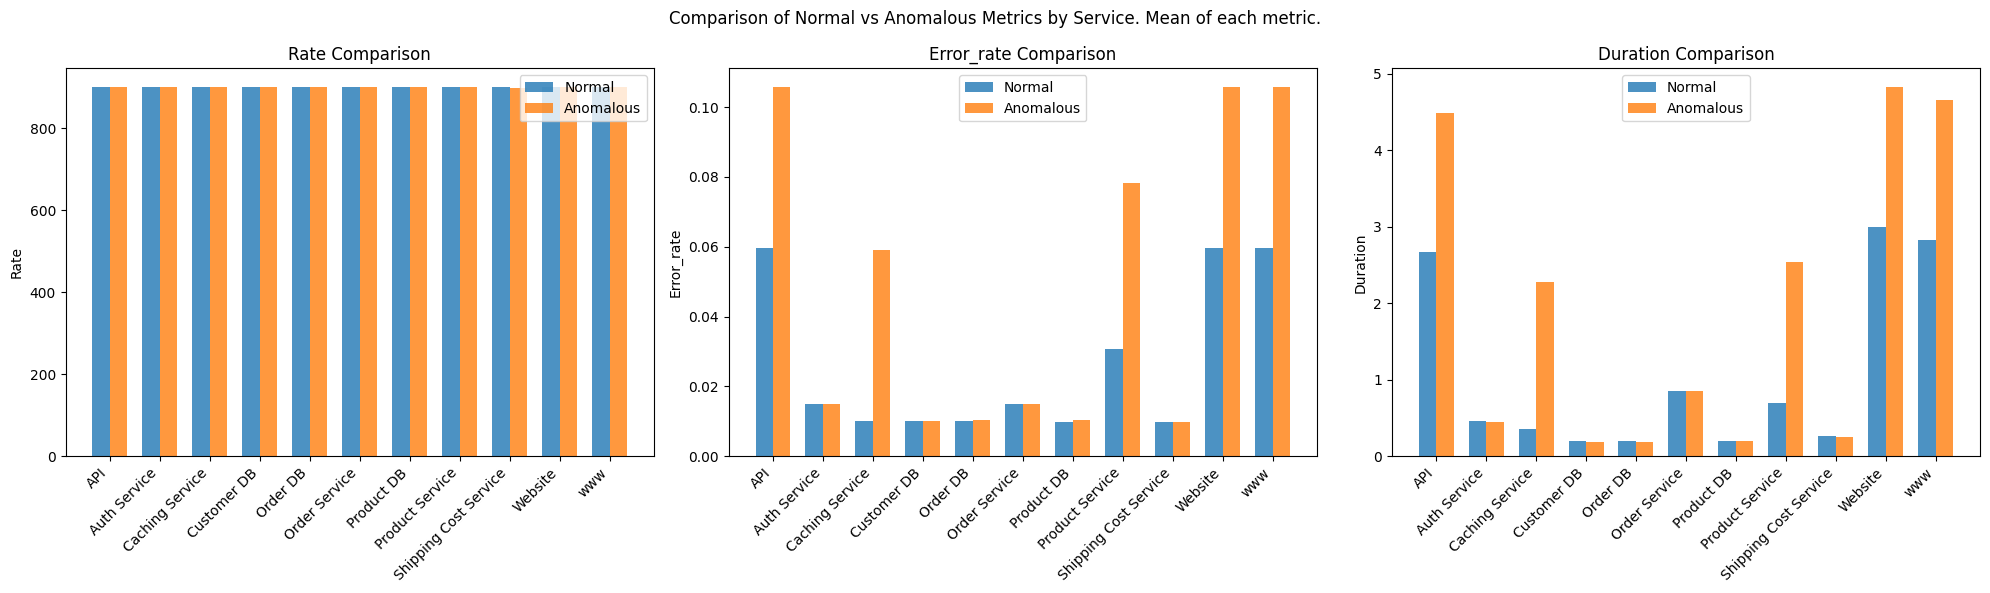

In [7]:
plot_normal_vs_anomalous_metrics(normal_data, anomalous_data) 

Notice, error rate and duration show changes at caching service and downstream nodes (as expected). Rate does not (as it's not affected in the simulation). 
Whether those assumptions on rate are reasonable... wellllllll.... we can think about that more later lol. 

In [11]:
# save it out!
normal_data.to_csv('simulated_multimetric_data/normal_data.csv')
anomalous_data.to_csv('simulated_multimetric_data/anomalous_data.csv')

In [12]:
# and here, i just manually copied the causal graph and target node from the single metric run. 